# Using Foursquare Location Data to Determine the Optimal Manhattan Neighborhood for a Sushi Restaurant
### Capstone Project - The Battle of Neighborhoods | Author: Jackson Viscomi
___

## 1. Introduction/Business Problem

When opening a new restaurant, the first two aspects that come into consideration are the **location** and the **competition**. 

A perspective restaurant owner wants their restaurant to be located in an area known for its food and bar scene, as that is where perspective customers will be located. However, they also want to make sure that they will not have too much competition between restaurants of the same category. This brings up the common problem of *"Where can I locate my restaurant so that it will attract the largest number of customers with the least amount of competition?"* 

Finding the answer to this problem difficult, however, with the help of data provided to us by Foursquare, we can use analytical machine learning to return a **list of optimal neighborhoods** with a **thriving restaurant scene** and **little competition**.

## 2. Analytical Approach and Data Requirements

Our stakeholders are going to be using this data to determine the best neighborhoods in **Manhattan, New York** to open a **Sushi Restaurant**. Therefore, our approach/requirements will consist of the following:

1. Obtaining a data frame of Manhattan neighborhoods and their corresponding latitude and longitude (obtained from the https://cocl.us/new_york_dataset JSON dataset)
2. Get foursquare data on popular venues in Manhattan (from a API request of: https://api.foursquare.com/v2/venues/exlpore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={})
2. Obtain the top 100 venues from each neighborhood by referencing the latitudes and longitudes from the previous dataframe 
3. Use one-hot encoding to produce a dataframe with a binary categorization of every venue. 
4. Group the dataframe by neighborhood, take averages of each binary value
5. Sum up binary averages for all venues with restaurant/food categories (i.e. anything containing "Resturant", "Bistro", "Pub" etc.) in each neighborhood, append to new datafreame.
6. Also append average count for "Sushi Restaurants" in each neighborhood to dataframe.
7. Use k-means clustering to divide neighborhoods into k-groups
8. Select group with highest restaurant sum, lowest "Sushi Restaurant" average

## 3. Data Collection, Preparation, and Modeling

Import all required libraries.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json
from geopy.geocoders import Nominatim 
import requests
from pandas.io.json import json_normalize 
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

WARNING conda.base.context:use_only_tar_bz2(632): Conda is constrained to only using the old .tar.bz2 file format because you have conda-build installed, and it is <3.18.3.  Update or remove conda-build to get smaller downloads and faster extractions.
Solving environment: failed

PackagesNotFoundError: The following packages are not available from current channels:

  - anaconda/linux-64::grpcio==1.16.1=py36hf8bcb03_1 -> openssl[version='>=1.1.1,<1.1.2.0a0']

Current channels:

  - https://conda.anaconda.org/conda-forge/linux-64
  - https://conda.anaconda.org/conda-forge/noarch
  - https://repo.anaconda.com/pkgs/main/linux-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/linux-64
  - https://repo.anaconda.com/pkgs/r/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




### 3a. Prepare Dataset

In [3]:
#fetch dataset containing each NYC neighborhood, along with its coordinates
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset

In [4]:
#load data
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [5]:
#narrow dataset to only the features portion
all_neighborhoods = newyork_data['features']

In [6]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods_df = pd.DataFrame(columns=column_names)

#loop that fills out the entire dataframe
for data in all_neighborhoods:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods_df = neighborhoods_df.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [7]:
#preview dataframe
neighborhoods_df.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [8]:
#create new dataframe with only Manhattan neighborhoods
manhattan_hoods = neighborhoods_df[neighborhoods_df['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_hoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


#### Import venue data from Foursquare 

In [9]:
CLIENT_ID = 'XLB1XHHHEDGSIGUR13KVG2MCZJYJ4IOHYSJ2LZ5EYXEJSGMY' # your Foursquare ID
CLIENT_SECRET = 'ATBDBJN1EO1TTZZURRXLQ2KOILZONIO4BG0JJFQWR4KWPCMX' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [10]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

#for loop which extracts the foursquare venue data based off the latitude and longitude coordinates of each neighborhood
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [11]:
#creates a dataframe with extracted data from above
all_manhattan_venues = getNearbyVenues(names=manhattan_hoods['Neighborhood'],
                                   latitudes=manhattan_hoods['Latitude'],
                                   longitudes=manhattan_hoods['Longitude']
                                  )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


### 3b. Explore and Analyze Venues Within Each Manhattan Neighborhood

turning the dataframe into binary values pertaining to the occurance of a specific type of venue within each neighborhood

In [12]:
# one hot encoding
manhattan_onehot = pd.get_dummies(all_manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = all_manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

#taking the mean values for each nieghboorhood 
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Green,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cambodian Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Bookstore,College Cafeteria,College Gym,College Theater,Comedy Club,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Nightlife,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Repair,Shoe Store

### 3c. Group all venues that are *restaurants, pubs, bars, cafes, etc.* together to create a 'total restaurant' average value

In [15]:
#Group all venues under the restauraunt and bar category using a list of identifying keywords
manhattan_grouped['Resturant_Avg'] = manhattan_grouped[['Afghan Restaurant',
 'African Restaurant',
 'American Restaurant',
 'Arepa Restaurant',
 'Argentinian Restaurant',
 'Asian Restaurant',
 'Australian Restaurant',
 'Austrian Restaurant',
 'BBQ Joint',
 'Bagel Shop',
 'Bakery',
 'Bar',
 'Beer Bar',
 'Beer Garden',
 'Beer Store',
 'Bistro',
 'Brazilian Restaurant',
 'Breakfast Spot',
 'Bubble Tea Shop',
 'Burger Joint',
 'Burrito Place',
 'Cafeteria',
 'Café',
 'Cambodian Restaurant',
 'Camera Store',
 'Cantonese Restaurant',
 'Caribbean Restaurant',
 'Caucasian Restaurant',
 'Chinese Restaurant',
 'Chocolate Shop',
 'Cocktail Bar',
 'Coffee Shop',
 'Comedy Club',
 'Convenience Store',
 'Creperie',
 'Cuban Restaurant',
 'Cupcake Shop',
 'Czech Restaurant',
 'Deli / Bodega',
 'Dessert Shop',
 'Dim Sum Restaurant',
 'Diner',
 'Dive Bar',
 'Donut Shop',
 'Dumpling Restaurant',
 'Duty-free Shop',
 'Eastern European Restaurant',
 'Empanada Restaurant',
 'English Restaurant',
 'Ethiopian Restaurant',
 'Falafel Restaurant',
 'Farmers Market',
 'Fast Food Restaurant',
 'Filipino Restaurant',
 'Fish Market',
 'Food & Drink Shop',
 'Food Court',
 'Food Stand',
 'Food Truck',
 'French Restaurant',
 'Fried Chicken Joint',
 'Frozen Yogurt Shop',
 'Furniture / Home Store',
 'Gaming Cafe',
 'Gastropub',
 'Gay Bar',
 'German Restaurant',
 'Greek Restaurant',
 'Hawaiian Restaurant',
 'Health Food Store',
 'Himalayan Restaurant',
 'Hot Dog Joint',
 'Hotel',
 'Hotel Bar',
 'Hotpot Restaurant',
 'Ice Cream Shop',
 'Indian Restaurant',
 'Irish Pub',
 'Israeli Restaurant',
 'Italian Restaurant',
 'Japanese Curry Restaurant',
 'Japanese Restaurant',
 'Jazz Club',
 'Jewish Restaurant',
 'Juice Bar',
 'Kebab Restaurant',
 'Korean Restaurant',
 'Kosher Restaurant',
 'Latin American Restaurant',
 'Lebanese Restaurant',
 'Liquor Store',
 'Lounge',
 'Malay Restaurant',
 'Market',
 'Mediterranean Restaurant',
 'Mexican Restaurant',
 'Middle Eastern Restaurant',
 'Modern European Restaurant',
 'Molecular Gastronomy Restaurant',
 'Moroccan Restaurant',
 'New American Restaurant',
 'Noodle House',
 'North Indian Restaurant',
 'Organic Grocery',
 'Other Nightlife',
 'Paella Restaurant',
 'Pakistani Restaurant',
 'Pastry Shop',
 'Persian Restaurant',
 'Peruvian Restaurant',
 'Pet Café',
 'Piano Bar',
 'Pie Shop',
 'Pizza Place',
 'Poke Place',
 'Pub',
 'Ramen Restaurant',
 'Restaurant',
 'Rock Club',
 'Russian Restaurant',
 'Sake Bar',
 'Salad Place',
 'Sandwich Place',
 'Scandinavian Restaurant',
 'Seafood Restaurant',
 'Shanghai Restaurant',
 'Snack Place',
 'Soba Restaurant',
 'Social Club',
 'Soup Place',
 'South American Restaurant',
 'South Indian Restaurant',
 'Southern / Soul Food Restaurant',
 'Spanish Restaurant',
 'Speakeasy',
 'Sports Bar',
 'Steakhouse',
 'Supermarket',
 'Sushi Restaurant',
 'Swiss Restaurant',
 'Szechuan Restaurant',
 'Taco Place',
 'Taiwanese Restaurant',
 'Tapas Restaurant',
 'Tea Room',
 'Thai Restaurant',
 'Tiki Bar',
 'Turkish Restaurant',
 'Udon Restaurant',
 'Vegetarian / Vegan Restaurant',
 'Venezuelan Restaurant',
 'Vietnamese Restaurant',
 'Whisky Bar',
 'Wine Bar',
 'Wine Shop',
 'Wings Joint',
 'Yoga Studio']].mean(axis=1)

In [16]:
#create new dataframe with only the required columns 
clusterdf = manhattan_grouped[['Neighborhood','Sushi Restaurant','Resturant_Avg']]

In [29]:
clusterdf.head(50)

,Neighborhood,Sushi Restaurant,Resturant_Avg
0,Battery Park City,0.020000,0.003248
1,Carnegie Hill,0.010000,0.004076
2,Central Harlem,0.000000,0.004198
3,Chelsea,0.010000,0.003949
4,Chinatown,0.000000,0.004586
5,Civic Center,0.020000,0.003694
6,Clinton,0.000000,0.004076
7,East Harlem,0.000000,0.004592
8,East Village,0.000000,0.005159
9,Financial District,0.000000,0.004395


In [17]:
#nomralize values for equal comparison
from sklearn import preprocessing
x = clusterdf[['Sushi Restaurant', 'Resturant_Avg']]
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
#create new dataframe with normalized values
clusterdf_nrml = pd.DataFrame(x_scaled)
clusterdf_nrml['Neighborhood'] = clusterdf['Neighborhood']
clusterdf_nrml.columns = ['Sushi Restaurant', 'Resturant_Avg', 'Neighborhood']
clusterdf_nrml = clusterdf_nrml[['Neighborhood','Sushi Restaurant', 'Resturant_Avg']]
clusterdf_nrml.head(25)

,Neighborhood,Sushi Restaurant,Resturant_Avg
0,Battery Park City,0.400000,0.454713
1,Carnegie Hill,0.200000,0.672115
2,Central Harlem,0.000000,0.704041
3,Chelsea,0.200000,0.638668
4,Chinatown,0.000000,0.805901
5,Civic Center,0.400000,0.571775
6,Clinton,0.000000,0.672115
7,East Harlem,0.000000,0.807456
8,East Village,0.000000,0.956410
9,Financial District,0.000000,0.755731


### 3d. Cluster Neighborhoods

Using k-means, we will cluster the neighborhoods into **5** clusters.

In [18]:
# set number of clusters
kclusters = 5

clusterdf_clustering = clusterdf_nrml.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(clusterdf_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 2, 0, 2, 0, 2, 2, 2, 2], dtype=int32)

In [19]:
# add clustering labels
clusterdf_nrml.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = manhattan_hoods

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(clusterdf_nrml.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Sushi Restaurant,Resturant_Avg
0,Manhattan,Marble Hill,40.876551,-73.910660,4,0.000000,0.502310
1,Manhattan,Chinatown,40.715618,-73.994279,2,0.000000,0.805901
2,Manhattan,Washington Heights,40.851903,-73.936900,0,0.229885,0.639822
3,Manhattan,Inwood,40.867684,-73.921210,2,0.000000,0.958619
4,Manhattan,Hamilton Heights,40.823604,-73.949688,3,0.655738,1.000000


### 3e. Visualize Reuslts

#### Use folium map of manhattan to visualize results of clustering

In [20]:
#put in map coordinates
address = 'New York City, NY'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


#### Visualize with clusters traditional scatter plot

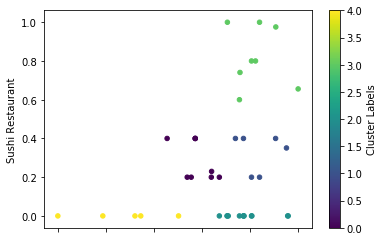

In [22]:
ax2 = manhattan_merged.plot.scatter(x='Resturant_Avg',
                        y='Sushi Restaurant',
                       c='Cluster Labels',
                    colormap='viridis')
ax2

As seen from the scatter plot, **cluster 2** (in yellow) has the highest restaurant average score and lowest sushi restaurant score, which fits both our requirements

#### Visualize Reuslts with Dataframe Tables

In [23]:
#create dataframe for cluster '0'
cluster1_df= manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
#create column on bottom row giving average for each value (except neighborhoods)
cluster1_df.loc['Average'] = cluster1_df.mean()
cluster1_df

,Neighborhood,Sushi Restaurant,Resturant_Avg
2,Washington Heights,0.229885,0.639822
8,Upper East Side,0.400000,0.571775
15,Midtown,0.400000,0.571775
17,Chelsea,0.200000,0.638668
21,Tribeca,0.200000,0.555052
28,Battery Park City,0.400000,0.454713
30,Carnegie Hill,0.200000,0.672115
32,Civic Center,0.400000,0.571775
38,Flatiron,0.200000,0.538329
Average,NaN,0.292209,0.579336


#### repeat process for dataframes '1'-'4'

In [24]:
cluster2_df=manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
cluster2_df.loc['Average'] = cluster2_df.mean()
cluster2_df

,Neighborhood,Sushi Restaurant,Resturant_Avg
12,Upper West Side,0.200000,0.805901
16,Murray Hill,0.400000,0.906240
24,West Village,0.400000,0.772454
25,Manhattan Valley,0.350877,0.951422
27,Gramercy,0.200000,0.839347
34,Sutton Place,0.400000,0.739008
Average,NaN,0.325146,0.835729


In [25]:
cluster3_df=manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
cluster3_df.loc['Average'] = cluster3_df.mean()
cluster3_df

,Neighborhood,Sushi Restaurant,Resturant_Avg
1,Chinatown,0.0,0.805901
3,Inwood,0.0,0.958619
6,Central Harlem,0.0,0.704041
7,East Harlem,0.0,0.807456
14,Clinton,0.0,0.672115
19,East Village,0.0,0.956410
20,Lower East Side,0.0,0.774950
22,Little Italy,0.0,0.705561
26,Morningside Heights,0.0,0.772454
29,Financial District,0.0,0.755731


In [26]:
cluster4_df=manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 3, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
cluster4_df.loc['Average'] = cluster4_df.mean()
cluster4_df

,Neighborhood,Sushi Restaurant,Resturant_Avg
4,Hamilton Heights,0.655738,1.000000
5,Manhattanville,0.975610,0.907056
9,Yorkville,0.800000,0.822624
10,Lenox Hill,1.000000,0.705561
18,Greenwich Village,0.800000,0.805901
31,Noho,0.600000,0.755731
35,Turtle Bay,1.000000,0.839347
36,Tudor City,0.740741,0.758002
Average,NaN,0.821511,0.824278


In [27]:
cluster5_df=manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 4, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
cluster5_df.loc['Average'] = cluster5_df.mean()
cluster5_df

,Neighborhood,Sushi Restaurant,Resturant_Avg
0,Marble Hill,0.0,0.502310
11,Roosevelt Island,0.0,0.345083
13,Lincoln Square,0.0,0.187141
23,Soho,0.0,0.320927
37,Stuyvesant Town,0.0,0.000000
Average,NaN,0.0,0.271092


As you see again, the **4th cluster** has a high total restuarnt score of .74, and a low sushi resturant score of .04 

## 4. Methodology

In this project we will direct our efforts on detecting areas of Manhattan that have high restaurant density, particularly those with low number of Sushi restaurants.

In the first step we used an exsisting dataframe, which contained the longitude and latitude of every neighborhood in New York City, and narrowed it down to strictly the neighborhoods in **Manhattan**. 

In our second step, using our previous dataframe, we made calls to the Foursquare API which returned the top 100 values for each neighboorhood, sorted according to the Foursquare categorization, and created a dataframes displaying each neighborhood's top 100 results in categorical binary format.   

In our third step, we created a dataframe with the average binary value for each neighboorhood, as well as a 'Total Restaurant Average' composed from the average of all resturant-related values within each neighborhood's top 100 list.

In our forth step, we prepared the data for clustering by eliminating all columns except the Neighborhood, Sushi Restaurant Average, and Total Restaurant Average. We then normalized the data to ensure an even comparison for each value. 

In our final step, we used the 'KMeans' algorithm from the Scikit-Learn library to categorize each neighboorhood into 1 of 5 clusters. Using data visualization and simple statistical analysis, we were able to find the cluster of Manhattan neighborhoods that met our specificaitons.

## 5. Results

The 5 categories that each neighborhood are summarized as follows:

* (***Cluster 0***) These neighborhoods had **VERY LITTLE sushi restaurant competiton** (average score of .033), but **did NOT have a vibrant restaurant scene** (average score of .209)  

* (***Cluster 1***) These neighborhoods had **BELOW average sushi restaurant competiton** (average score of .279), but had an **AVERAGE restaurant scene** (average score of .533)

* (***Cluster 2***) These neighborhoods had **VERY HIGH sushi restaurant competiton** (average score of .900), and had a **VERY vibrant restaurant scene** (average score of .761)

* (***Cluster 3***) These neighborhoods had **AVERGE average sushi restaurant competiton** (average score of .465), but had an **EXTREMELY vibrant restaurant scene*** (average score of .823)

* (***Cluster 4***) These neighborhoods had **VERY LITTLE average sushi restaurant competiton** (average score of .043), but had an **VERY vibrant restaurant scene*** (average score of .741)

## 6. Discussion/Conclusion

The original questions asked by our stakeholders was to indentifiy neighboorhoods that would be a good fit for a new sushi restaurnt, by the means of identifying which neighborhoods had thriving restaurant scenes while having little sushi restaurant competition.

Judging from our results, we see **Cluster 4** as the ideal cluster of neighboorhoods, as each neighborhood fufills the requirments of having a vibrant restaurant scene, with little sushi competition. Therefore, based off our analysis, the location for the new sushi restaurant should be within the following neighborhoods: 

- Hudson Yards
- Midtown South
- Financial District 
- Gramercy
- Morningside Heights
- Little Italy
- Lower East Side
- East Village
- Clinton
- Upper West Side
- East Harlem 
- Central Harlem 
- Inwood 
- Chinatown

To further narrow down the results, we reccomend reseraching into additional neighborhood factors that could predict a sushi restaurant's sucess. One idea would be to research historial neighboorhood demographics and the sucess of sushi resturants within them. That data can then be used as a classifier for a potential sushi restaurant's sucsess, and be applied on the current cluster to achieve a shorter list of more confident reccomendations. 